# Experimentation: Digitally Reconstructed Radiography (DRR)
---

[Gopalakrishnan and Golland, 2022](https://doi.org/10.1007/978-3-031-23179-7_1) presented a method for solving inverse problems in intraoperative imaging using fast auto-differentiable digitally reconstructed radiographs. In this notebook, we apply the method described in their work to solve a similar problem in our analysis.

`DiffDRR` is implemented as a custom PyTorch module.

In [1]:
# Import libraries
import sys

sys.path.append("..")

from src.preprocessing import get_transforms, get_datasets, get_dataloaders
from src.utils import get_spacing, get_iso_center

import torch
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

from diffdrr.drr import DRR
from diffdrr.visualization import plot_drr
from diffdrr.data import read

from diffdrr.pose import convert
from diffdrr.visualization import drr_to_mesh, img_to_mesh
import pyvista

# Set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Application for Abdominal CT Scans

In [2]:
# Get transforms
transform = get_transforms(contrast_value=1000)

# Get datasets
train_ds, val_ds = get_datasets(root_dir="../data", collection="HCC-TACE-Seg", transform=transform, download_len=5, val_frac=0.2)

# Get dataloaders
train_loader, val_loader = get_dataloaders(train_ds, val_ds, batch_size=1)

# Get datalists
train_dl = train_ds.datalist
val_dl = val_ds.datalist
 
# Check length of datasets, dataloaders and datalists
print(train_ds.get_indices(), val_ds.get_indices())
print(len(train_loader), len(val_loader))
print(len(train_dl), len(val_dl))

2024-04-25 16:11:23,717 - INFO - Expected md5 is None, skip md5 check for file ..\data\HCC-TACE-Seg\1.2.276.0.7230010.3.1.3.8323329.41.1604860085.518229.zip.
2024-04-25 16:11:23,717 - INFO - File exists: ..\data\HCC-TACE-Seg\1.2.276.0.7230010.3.1.3.8323329.41.1604860085.518229.zip, skipped downloading.
2024-04-25 16:11:23,717 - INFO - Writing into directory: ..\data\HCC-TACE-Seg\raw\1.2.276.0.7230010.3.1.3.8323329.41.1604860085.518229.
2024-04-25 16:11:24,240 - INFO - Expected md5 is None, skip md5 check for file ..\data\HCC-TACE-Seg\1.3.6.1.4.1.14519.5.2.1.1706.8374.172517341095680731665822868712.zip.
2024-04-25 16:11:24,240 - INFO - File exists: ..\data\HCC-TACE-Seg\1.3.6.1.4.1.14519.5.2.1.1706.8374.172517341095680731665822868712.zip, skipped downloading.
2024-04-25 16:11:24,240 - INFO - Writing into directory: ..\data\HCC-TACE-Seg\HCC_017\300\image.
2024-04-25 16:11:24,542 - INFO - Expected md5 is None, skip md5 check for file ..\data\HCC-TACE-Seg\1.2.276.0.7230010.3.1.3.8323329.208

In [3]:
# Check the first batch
batch = next(iter(train_loader))

Data statistics:
Type: <class 'monai.data.meta_tensor.MetaTensor'> torch.float32
Shape: torch.Size([1, 512, 512, 96])
Value range: (-2048.0, 4071.0)
Data statistics:
Type: <class 'monai.data.meta_tensor.MetaTensor'> torch.float32
Shape: torch.Size([5, 512, 512, 96])
Value range: (0.0, 1.0)


In [4]:
# Separate the image and segmentation from the batch
image, seg = batch["image"], batch["seg"]

# Print useful information about the image and segmentation
print(image.shape, seg.shape)
print(image.dtype, seg.dtype)
print(type(image), type(seg))

# Print the metadata of the image
print(image.meta)

torch.Size([1, 1, 512, 512, 96]) torch.Size([1, 5, 512, 512, 96])
torch.float32 torch.float32
<class 'monai.data.meta_tensor.MetaTensor'> <class 'monai.data.meta_tensor.MetaTensor'>
{spatial_shape: [tensor([512]), tensor([512]), tensor([63])], '00200032': {'vr': ['DS'], 'Value': [tensor([-176.4000], dtype=torch.float64), tensor([-180.], dtype=torch.float64), tensor([-65.], dtype=torch.float64)]}, original_channel_dim: tensor([nan], dtype=torch.float64), original_affine: tensor([[[ -0.7031,   0.0000,   0.0000, 176.4000],
         [  0.0000,  -0.7031,   0.0000, 180.0000],
         [  0.0000,   0.0000,  -2.5000, -65.0000],
         [  0.0000,   0.0000,   0.0000,   1.0000]]], dtype=torch.float64), '00280030': {'vr': ['DS'], 'Value': [tensor([0.7031], dtype=torch.float64), tensor([0.7031], dtype=torch.float64), tensor([2.5000], dtype=torch.float64)]}, '00200037': {'vr': ['DS'], 'Value': [tensor([1.], dtype=torch.float64), tensor([0.], dtype=torch.float64), tensor([0.], dtype=torch.float64),

torch.Size([512, 512]) torch.Size([512, 512])


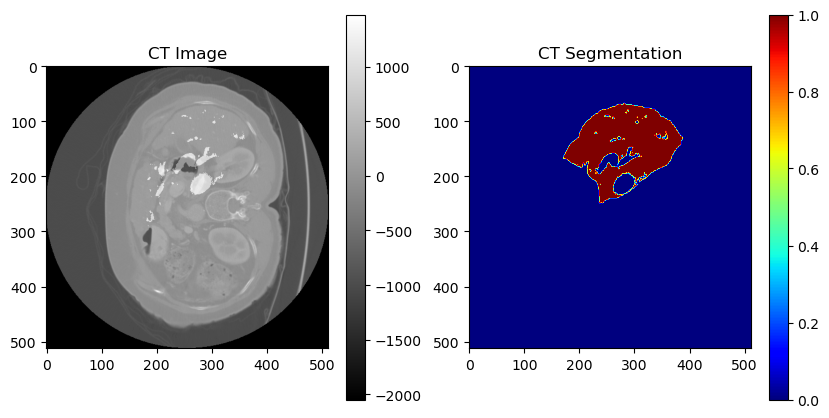

In [5]:
slice_idx = 60

# Sample a slice from the image
CT_slice = image[0, 0, :, :, slice_idx].cpu()

# Get the maximum segmentation class for each pixel in the slice
CT_seg_slice = seg[0, 0, :, :, slice_idx].cpu()

print(CT_slice.shape, CT_seg_slice.shape)

# Plot the image and segmentation slice as a subplot
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
im = axes[0].imshow(
    CT_slice, cmap="gray"
) 
axes[0].set_title("CT Image")
fig.colorbar(im, ax=axes[0])  # Add a colorbar to the CT image
axes[1].imshow(CT_seg_slice, cmap="jet")
axes[1].set_title("CT Segmentation")
plt.colorbar(mappable=axes[1].imshow(CT_seg_slice, cmap="jet"), ax=axes[1])
plt.show()

In [6]:
volume, spacing = get_spacing(image)
x, y, z = get_iso_center(volume, spacing)
x, y, z = torch.tensor([x, y, z])
print(type(volume), type(spacing), type(x), type(y), type(z))
print(x, y, z)

<class 'numpy.ndarray'> <class 'list'> <class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
tensor(180.) tensor(180.) tensor(120.)


In [8]:
SD = 600
px, py = 0.703125, 0.703125

drr = DRR(

    volume,  # The CT volume as a numpy array

    spacing,  # Voxel dimensions of the CT

    sdr=SD / 2,  # Source-to-detector radius (half of the source-to-detector distance)

    height=200,  # Height of the DRR (if width is not seperately provided, the generated image is square)

    width=200,  # Width of the DRR
    delx= 4.0,  # Pixel spacing (in mm)
    renderer="siddon",  # Rendering method

).to(device)

AttributeError: 'numpy.ndarray' object has no attribute 'reorient'

In [9]:
# Set the camera pose with rotations (yaw, pitch, roll) and translations (x, y, z)
rotations = torch.tensor([[torch.pi, 0.0, torch.pi / 2]], device=device)
translations = torch.tensor([[x, y, z]], device=device)
print(type(rotations), type(translations))
print(rotations.shape, translations.shape)
print(rotations, translations)

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([1, 3]) torch.Size([1, 3])
tensor([[3.1416, 0.0000, 1.5708]], device='cuda:0') tensor([[180., 180., 120.]], device='cuda:0')


In [10]:
img_liver = drr(
    rotations,
    translations,
    parameterization="euler_angles",
    convention="ZYX",
    bone_attenuation_multiplier=1.0,
)

NameError: name 'drr' is not defined

In [11]:
# Plot the DRR
plot_drr(img_liver, ticks=False)
plt.show()

NameError: name 'img_liver' is not defined

In [12]:
# Make a mesh from the CT volume
ct = drr_to_mesh(drr, "surface_nets", threshold=1150, verbose=False)

# Make a mesh from the camera and detector plane
pose = convert(rotations, translations, parameterization="euler_angles", convention="ZYX")
camera, detector, texture, principal_ray = img_to_mesh(drr, pose)

# Make the plot
plotter = pyvista.Plotter()
plotter.add_mesh(ct)
plotter.add_mesh(camera, show_edges=True, line_width=1.5)
plotter.add_mesh(principal_ray, color="lime", line_width=3)
plotter.add_mesh(detector, texture=texture)

# Render the plot
plotter.add_axes()
plotter.add_bounding_box()

plotter.show()  # If running Jupyter locally
# plotter.show(jupyter_backend="server")  # If running Jupyter remotely
#plotter.export_html("render.html")

NameError: name 'drr' is not defined

In [13]:
import numpy as np

SDR = 300


true_params = {
    "sdr": SDR,
    "alpha": torch.pi,
    "beta": 0,
    "gamma": torch.pi / 2,
    "bx": x,
    "by": y,
    "bz": z,
}

# Make a random DRR
def get_initial_parameters(true_params):
    alpha = true_params["alpha"] + np.random.uniform(-np.pi / 4, np.pi / 4)
    beta = true_params["beta"] + np.random.uniform(-np.pi / 3, np.pi / 3)
    gamma = true_params["gamma"] + np.random.uniform(-np.pi / 3, np.pi / 3)
    bx = true_params["bx"] + np.random.uniform(-30.0, 31.0)
    by = true_params["by"] + np.random.uniform(-30.0, 31.0)
    bz = true_params["bz"] + np.random.uniform(-30.0, 31.0)
    rotation = torch.tensor([[alpha, beta, gamma]]).to(device)
    translation = torch.tensor([[bx, by, bz]]).to(device)
    return rotation, translation


rotations, translations = get_initial_parameters(true_params)
drr = DRR(volume, spacing, sdr=SDR, height=100, delx=4.0).to(device)
with torch.no_grad():
    est = drr(
        rotations,
        translations,
        parameterization="euler_angles",
        convention="ZYX",
    )
plot_drr(est)
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'reorient'

### First Implement a simple DRR projection

In [14]:
print(image.shape)
print(image.unique())

torch.Size([1, 1, 512, 512, 96])
metatensor([-2048.0000, -1024.0000, -1023.5000,  ...,  4055.0000,  4063.0000,
         4071.0000])


In [24]:
# Sum along the depth axis (axis=-1 for the last axis)
projection = image.sum(dim=-1)

# Normalize to the range 0-1
min_val = projection.min()
max_val = projection.max()
normalized_projection = (projection - min_val) / (max_val - min_val)

print(normalized_projection.shape)
print(normalized_projection.unique())

torch.Size([1, 1, 512, 512])
metatensor([0.0000, 0.3936, 0.3937,  ..., 0.9995, 0.9998, 1.0000])


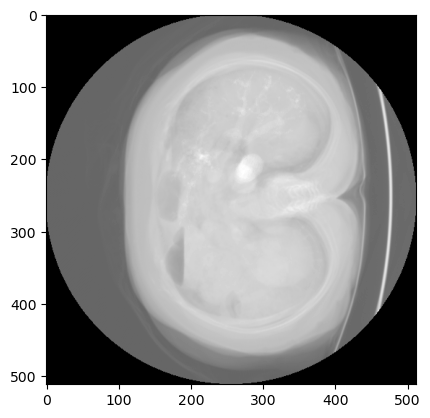

In [25]:
import matplotlib.pyplot as plt

# Visualize the projection
plt.imshow(normalized_projection[0, 0], cmap="gray")

In [2]:
import os

# Replace '/path/to/new/temp/dir' with a path on a disk with enough space
os.environ['TMPDIR'] = 'D:/temp'

from monai.apps import TciaDataset, DecathlonDataset
from monai.data import DataLoader

ds = DecathlonDataset(root_dir="../data/Task08_HepaticVessel", task="Task08_HepaticVessel", section="training", download=True)

Task08_HepaticVessel.tar:  81%|████████  | 7.01G/8.71G [1:54:54<18:31, 1.64MB/s]  